# GD y SGD

# Contenido


- [1](#section-1) Definicion de funciones:
  - [1.1](#subsection-1.1) Funcion Cuadratica
  - [1.2](#subsection-1.2) Funcion Eason 2D
  - [1.3](#subsection-1.3) Algoritmo Gradiente Descendiente (GD)
  - [1.4](#subsection-1.4) Algoritmo Gradiente Descendiente Estocastico (SGD)
  
- [2](#section-2) Evaluacion de GD:
  - [2.1](#subsection-2.1) Funcion Cuadratica
  - [2.2](#subsection-2.2) Funcion Eason
  
- [3](#section-3) Evaluacion de SGD:
  - [3.1](#subsection-3.1) Funcion Eason
  
- [4](#section-4) Comparacion de GD y SGD
  

# 1 <a id="section-1"></a> Definicion de Funciones:

Se definen las funciones a emplear a lo largo del desarrollo.

## 1.1 <a id="subsection-1.1"></a> Función cuadrática:
$$ \text{Costo: }F(X)=0.5*\|Ax-b\|_{2}^{2}  $$
 
$$ \text{Gradiente: }\nabla F(X)=2A^{T}Ax-2A^{T}b $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests, gzip, os, hashlib
import time
from numpy import linalg as LA
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D

# Costo de la funcion cuadratica

def cost_quadratic_fun(A, x, b):
    
    cost = 0.5*np.linalg.norm(A.dot(x)-b, ord=2)
    
    return cost;


# Gradiente de la funcion cuadratica

def gradient_quadratic_fun(A, x, b):

    gradient = 2*np.dot(np.transpose(A), np.dot(A,x)) - 2*np.dot(np.transpose(A), b)
    
    return gradient;

## 1.2<a id="subsection-1.2"></a> Función de Eason


$$ \text{Costo: }F(X)=-\text{cos}(x[0])\cdot\text{cos}(x[1])\cdot e^{-(x[0]-\pi){{}^2}-(x[1]-\pi){{}^2}} $$

$$ \text{Gradiente Taylor: }\nabla F(x_{k})[n]=(E[x_{k}[1-n]])\cdot\Sigma_{l}\frac{A^{(l)}[x_{k-1}[n]]}{l!}(x_{k}[n]-x_{k-1}[n])^{l} $$

$$ E[x[n]]=(\text{cos}(x[n])\cdot e^{-(x[n]-\pi){{}^2}}) $$
$$ A[x[n]]=(\text{sin}(x[n])\cdot e^{-(x[n]-\pi){{}^2}}+2\cdot(x[n]-\pi)\cdot\text{cos}(x[n])e^{-(x[n]-\pi){{}^2}}) $$

In [2]:
# Costo de la funcion de Eason

def cost_eason_fun(x):
    
    cost = -np.cos(x[0])*np.cos(x[1])*np.exp(-(x[0]-np.pi)**2-(x[1]-np.pi)**2)
    
    return cost;

# Aproximacion de Taylor de la gradiente de la funcion de Eason

def gradient_eason_taylor(x, x_ant, l_k):
    gradient = np.zeros([2,1])
    
    x_var = sp.Symbol('x_var')
    A_fun = sp.sin(x_var) * sp.exp(-(x_var-sp.pi)**2) + 2 * (x_var-sp.pi) * sp.cos(x_var) * sp.exp(-(x_var-sp.pi)**2)

    for l in range(len(l_k)):
        deriv_order = l_k[l]

        A_diff_x0 = A_fun.diff(x_var, deriv_order).evalf(subs={x_var: float(x_ant[0])})
        A_diff_x1 = A_fun.diff(x_var, deriv_order).evalf(subs={x_var: float(x_ant[1])})
             
        gradient[0] = gradient[0] + (A_diff_x0/np.math.factorial(deriv_order))*(x[0]-x_ant[0])**deriv_order
        gradient[1] = gradient[1] + (A_diff_x1/np.math.factorial(deriv_order))*(x[1]-x_ant[1])**deriv_order
    
    E_x0 = np.cos(x[0])*np.exp(-(x[0]-np.pi)**2)
    E_x1 = np.cos(x[1])*np.exp(-(x[1]-np.pi)**2)
    
    gradient[0] = gradient[0]*E_x1
    gradient[1] = gradient[1]*E_x0
    
    return gradient;

## 1.3<a id="subsection-1.3"></a> Algoritmo Gradiente Descendiente (GD)

In [3]:
def GD(Iters, x, alpha, fun_name, A=None, b=None):

    cost = np.zeros([Iters+1,1])
    time_iter = np.zeros([Iters+1,1])
    
    #Funcion de Costo
    if fun_name == 'quadratic':
        cost[0] = cost_quadratic_fun(A, x, b)
    elif fun_name == 'eason_taylor':
        cost[0] = cost_eason_fun(x)
        l_k = np.arange(10)
        x_ant = np.zeros([2,1])
        

    #Tiempo
    time_iter[0] = 0
    t = time.time()
        
    for i in range(Iters):
    
        #Gradiente
        if fun_name == 'quadratic':
            gradient = gradient_quadratic_fun(A, x, b)           
        elif fun_name == 'eason_taylor':
            gradient = gradient_eason_taylor(x, x_ant, l_k)

        if fun_name == 'eason_taylor':   
            x_ant = x

        #Actualizacion
        x = x - alpha*gradient

        #Funcion de Costo
        if fun_name == 'quadratic':
            cost[i+1] = cost_quadratic_fun(A, x, b)
        elif fun_name == 'eason_taylor':
            cost[i+1] = cost_eason_fun(x)
        
        time_iter[i+1] = time.time() - t 
        
    return cost, time_iter, x


## 1.4<a id="subsection-1.4"></a>  Algoritmo Gradiente Descendiente Estocastico (SGD)

In [4]:
def SGD(Epochs, x, alpha, total_size, batch_size):
    
    iters_per_epoch = int(total_size/batch_size)
    cost = np.zeros([Epochs+1,1])
    time_epoch = np.zeros([Epochs+1,1])
    
    #Funcion de Costo
    cost[0] = cost_eason_fun(x)
    
    x_ant = np.zeros([2,1])

    #Tiempo
    time_epoch[0] = 0
    t = time.time()

    for i in range(Epochs):
    
        R = np.random.permutation(total_size)
        
        for j in range(iters_per_epoch):
        
            l_k = R[j*batch_size:(j+1)*batch_size]
        
            #Gradiente
            gradient_R =  gradient_eason_taylor(x, x_ant, l_k)
            x_ant = x
            x = x - alpha*gradient_R
            
        #Función de Costo
        cost[i+1] = cost_eason_fun(x)
        
        time_epoch[i+1] = time.time() - t 
        
    return cost, time_epoch, x
    

# 2<a id="section-2"></a> Evaluacion GD

Se evalua el algoritmo de gradiente descendiente para los casos de la funcion cuadratica y eason.

## Iniciacización de parámentros

In [5]:
#GD
Iters = 100
data_len = 28
N = np.array([500, 1000, 2000])
alpha_GD = 0.0001

## 2.1<a id="subsection-2.1"></a> Funcion Cuadratica

Se escogen 3 tamanos de paso en los cuales se pueda apreciar cuando la funcion tiene una convergencia muy lenta, el caso optimo y cuando la funcion diverge, para los casos N = {500, 1000, 2000}.

### N = 500

In [6]:
#Funcion Cuadratica 500 valores
sigma = 0.001
A = np.random.randn(N[0],N[0])
x0 = np.random.randn(N[0])
b = np.dot(A,x0) + sigma*np.random.randn(N[0])
x = np.random.randn(N[0])
fun_name = 'quadratic'

alpha_GD = 0.0006
cost_GD_quadratic_fun_500_alpha1, time_GD_quadratic_fun_500_alpha1, x_GD_quadratic_fun_500_alpha1 = GD(Iters, x, alpha_GD, fun_name, A, b)
alpha_GD = 0.0004
cost_GD_quadratic_fun_500_alpha2, time_GD_quadratic_fun_500_alpha2, x_GD_quadratic_fun_500_alpha2 = GD(Iters, x, alpha_GD, fun_name, A, b)
alpha_GD = 0.00001
cost_GD_quadratic_fun_500_alpha3, time_GD_quadratic_fun_500_alpha3, x_GD_quadratic_fun_500_alpha3 = GD(Iters, x, alpha_GD, fun_name, A, b)

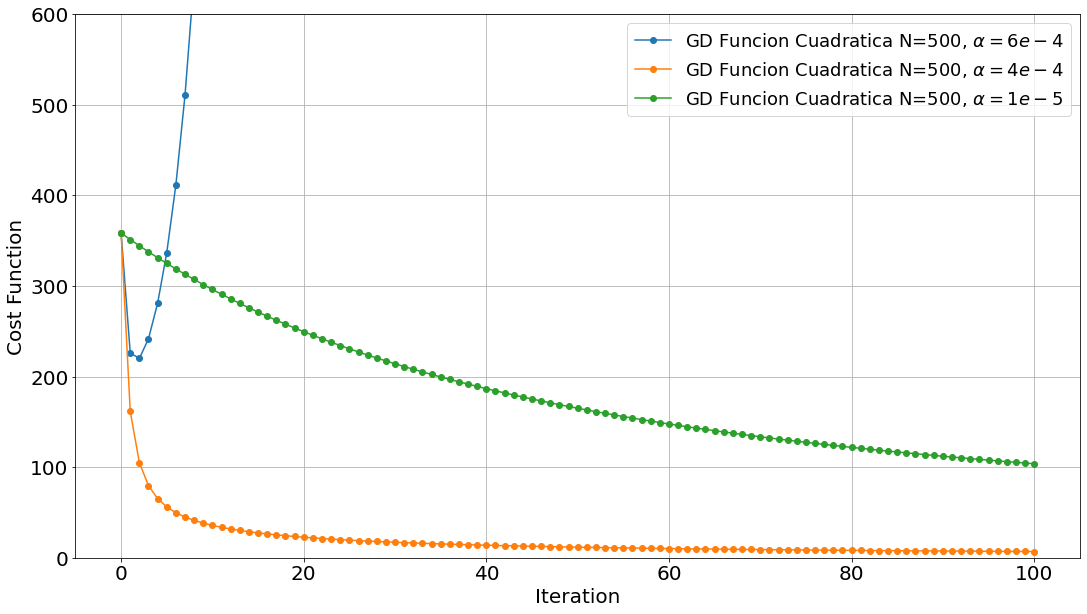

In [7]:
lsize = 20

plt.figure(figsize=(18,10))
plt.plot(cost_GD_quadratic_fun_500_alpha1, '-o', label='GD Funcion Cuadratica N=500, $\\alpha=6e-4$')
plt.plot(cost_GD_quadratic_fun_500_alpha2, '-o', label='GD Funcion Cuadratica N=500, $\\alpha=4e-4$')
plt.plot(cost_GD_quadratic_fun_500_alpha3, '-o', label='GD Funcion Cuadratica N=500, $\\alpha=1e-5$')
plt.ylim([0, 600])
plt.grid('on')
plt.xlabel('Iteration', fontsize= lsize)
plt.ylabel('Cost Function', fontsize= lsize)
plt.legend(loc='upper right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)

plt.show()

### N = 1000

In [8]:
#Funcion Cuadratica 1000 valores
A = np.random.randn(N[1],N[1])
x0 = np.random.randn(N[1])
b = np.dot(A,x0) + sigma*np.random.randn(N[1])
x = np.random.randn(N[1])

alpha_GD = 0.0003
cost_GD_quadratic_fun_1000_alpha1, time_GD_quadratic_fun_1000_alpha1, x_GD_quadratic_fun_1000_alpha1 = GD(Iters, x, alpha_GD, fun_name, A, b)
alpha_GD = 0.00025
cost_GD_quadratic_fun_1000_alpha2, time_GD_quadratic_fun_1000_alpha2, x_GD_quadratic_fun_1000_alpha2 = GD(Iters, x, alpha_GD, fun_name, A, b)
alpha_GD = 0.00001
cost_GD_quadratic_fun_1000_alpha3, time_GD_quadratic_fun_1000_alpha3, x_GD_quadratic_fun_1000_alpha3 = GD(Iters, x, alpha_GD, fun_name, A, b)

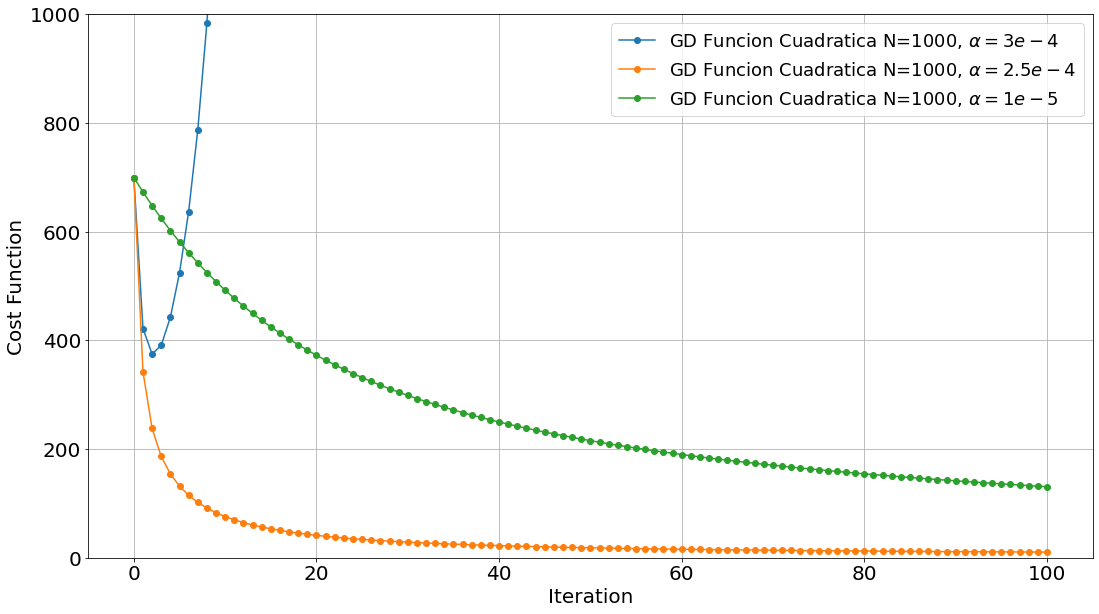

In [9]:
plt.figure(figsize=(18,10))
plt.plot(cost_GD_quadratic_fun_1000_alpha1, '-o', label='GD Funcion Cuadratica N=1000, $\\alpha=3e-4$')
plt.plot(cost_GD_quadratic_fun_1000_alpha2, '-o', label='GD Funcion Cuadratica N=1000, $\\alpha=2.5e-4$')
plt.plot(cost_GD_quadratic_fun_1000_alpha3, '-o', label='GD Funcion Cuadratica N=1000, $\\alpha=1e-5$')
plt.ylim([0, 1000])

plt.grid('on')
plt.xlabel('Iteration', fontsize= lsize)
plt.ylabel('Cost Function', fontsize= lsize)
plt.legend(loc='upper right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)

plt.show()

### N = 2000

In [10]:
#Funcion Cuadratica 2000 valores
A = np.random.randn(N[2],N[2])
x0 = np.random.randn(N[2])
b = np.dot(A,x0) + sigma*np.random.randn(N[2])
x = np.random.randn(N[2])

alpha_GD = 0.00015
cost_GD_quadratic_fun_2000_alpha1, time_GD_quadratic_fun_2000_alpha1, x_GD_quadratic_fun_2000_alpha1 = GD(Iters, x, alpha_GD, fun_name, A, b)
alpha_GD = 0.0001
cost_GD_quadratic_fun_2000_alpha2, time_GD_quadratic_fun_2000_alpha2, x_GD_quadratic_fun_2000_alpha2 = GD(Iters, x, alpha_GD, fun_name, A, b)
alpha_GD = 0.00001
cost_GD_quadratic_fun_2000_alpha3, time_GD_quadratic_fun_2000_alpha3, x_GD_quadratic_fun_2000_alpha3 = GD(Iters, x, alpha_GD, fun_name, A, b)

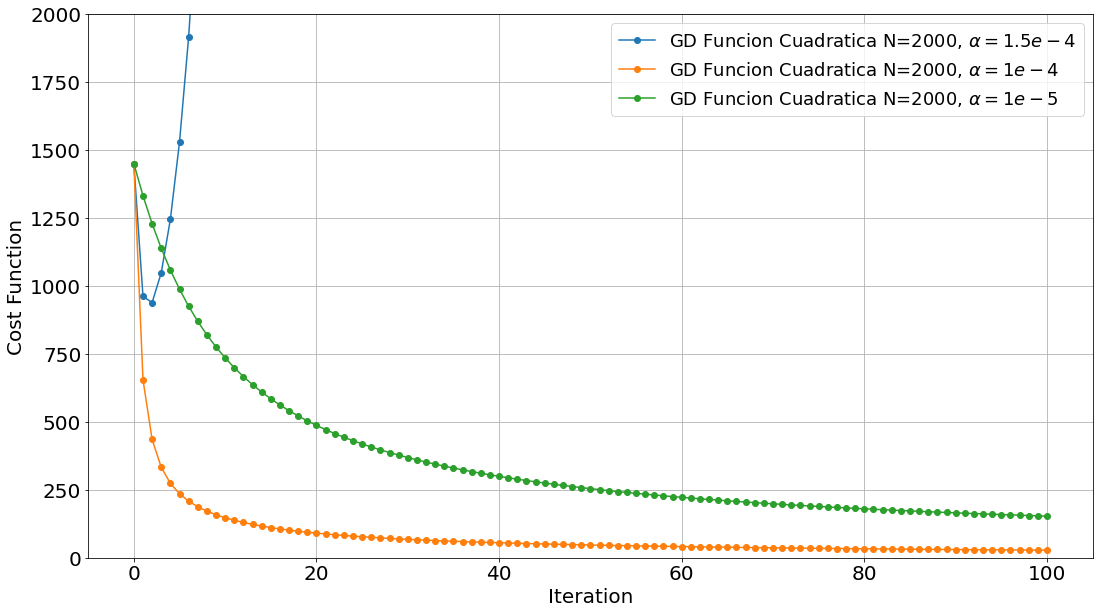

In [11]:

plt.figure(figsize=(18,10))
plt.plot(cost_GD_quadratic_fun_2000_alpha1, '-o', label='GD Funcion Cuadratica N=2000, $\\alpha=1.5e-4$')
plt.plot(cost_GD_quadratic_fun_2000_alpha2, '-o', label='GD Funcion Cuadratica N=2000, $\\alpha=1e-4$')
plt.plot(cost_GD_quadratic_fun_2000_alpha3, '-o', label='GD Funcion Cuadratica N=2000, $\\alpha=1e-5$')
plt.ylim([0, 2000])
plt.grid('on')
plt.xlabel('Iteration', fontsize= lsize)
plt.ylabel('Cost Function', fontsize= lsize)
plt.legend(loc='upper right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)

plt.show()

## 2.2<a id="subsection-2.2"></a> Funcion Eason 2D

Se escogen 3 tamanos de paso en los cuales se pueda apreciar cuando la funcion tiene una convergencia muy lenta, el caso optimo y cuando la funcion diverge. Para el caso de GD, se emplea la aproximacion de Taylor con $L=10$ en cada una de las 50 iteraciones.

In [12]:
#Funcion de Eason
Iters = 50

x0 = np.random.randn(2,1)
x0[0] = x0[0] + 7/3
x0[1] = x0[1] + 8/3
x = x0
fun_name = 'eason_taylor'

alpha_GD = 1
cost_GD_eason_taylor_fun_alpha1, time_GD_eason_taylor_fun_alpha1, x_GD_eason_taylor_fun_alpha1 = GD(Iters, x, alpha_GD, fun_name)

alpha_GD = 0.1
cost_GD_eason_taylor_fun_alpha2, time_GD_eason_taylor_fun_alpha2, x_GD_eason_taylor_fun_alpha2 = GD(Iters, x, alpha_GD, fun_name)

alpha_GD = 0.01
cost_GD_eason_taylor_fun_alpha3, time_GD_eason_taylor_fun_alpha3, x_GD_eason_taylor_fun_alpha3 = GD(Iters, x, alpha_GD, fun_name)

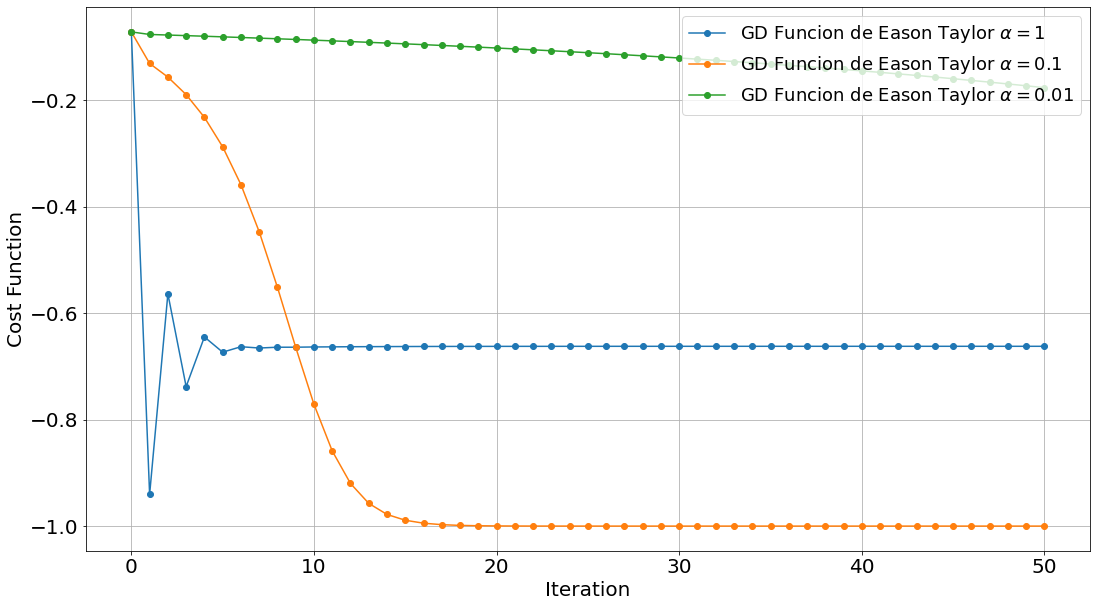

In [13]:
plt.figure(figsize=(18,10))
plt.plot(cost_GD_eason_taylor_fun_alpha1, '-o', label='GD Funcion de Eason Taylor $\\alpha=1$')
plt.plot(cost_GD_eason_taylor_fun_alpha2, '-o', label='GD Funcion de Eason Taylor $\\alpha=0.1$')
plt.plot(cost_GD_eason_taylor_fun_alpha3, '-o', label='GD Funcion de Eason Taylor $\\alpha=0.01$')

plt.grid('on')
plt.xlabel('Iteration', fontsize= lsize)
plt.ylabel('Cost Function', fontsize= lsize)
plt.legend(loc='upper right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)

plt.show()

# 3<a id="section-3"></a> Evaluacion SGD

## 3.1<a id="subsection-3.1"></a> Funcion Eason 2D

Se escogen 3 tamanos de paso en los cuales se pueda apreciar cuando la funcion tiene una convergencia muy lenta, el caso optimo y cuando la funcion diverge. Para el caso de SGD, se emplea la aproximacion de Taylor con $L=10$ y 2 valores de estos por cada iteracion de cada epoca, es decir son 5 iteraciones con tamano de batch de 2 por epoca para poder evaluar todos los valores de la sumatoria de la aproximacion de Taylor. Se evaluan 50 epocas.

In [14]:
#SGD
Epochs = 50
total_size = 10
batch_size = 2

In [15]:
alpha_SGD = 1
cost_SGD_eason_taylor_fun_alpha1, time_SGD_eason_taylor_fun_alpha1, x_SGD_eason_taylor_fun_alpha1 = SGD(Epochs, x, alpha_SGD, total_size, batch_size)
alpha_SGD = 0.1
cost_SGD_eason_taylor_fun_alpha2, time_SGD_eason_taylor_fun_alpha2, x_SGD_eason_taylor_fun_alpha2 = SGD(Epochs, x, alpha_SGD, total_size, batch_size)
alpha_SGD = 0.01
cost_SGD_eason_taylor_fun_alpha3, time_SGD_eason_taylor_fun_alpha3, x_SGD_eason_taylor_fun_alpha3 = SGD(Epochs, x, alpha_SGD, total_size, batch_size)

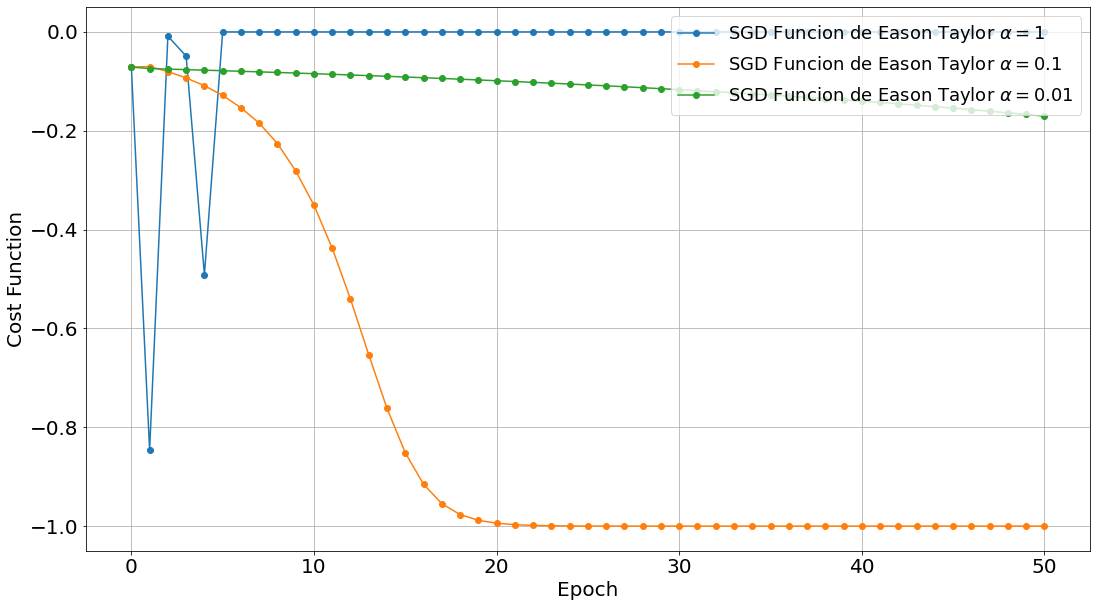

In [16]:
plt.figure(figsize=(18,10))
plt.plot(cost_SGD_eason_taylor_fun_alpha1, '-o', label='SGD Funcion de Eason Taylor $\\alpha=1$')
plt.plot(cost_SGD_eason_taylor_fun_alpha2, '-o', label='SGD Funcion de Eason Taylor $\\alpha=0.1$')
plt.plot(cost_SGD_eason_taylor_fun_alpha3, '-o', label='SGD Funcion de Eason Taylor $\\alpha=0.01$')

plt.grid('on')
plt.xlabel('Epoch', fontsize= lsize)
plt.ylabel('Cost Function', fontsize= lsize)
plt.legend(loc='upper right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)

plt.show()

# 4<a id="section-4"></a> Comparación GD y SGD

Se comparan los algoritmos GD y SGD para el caso de la funcion Eason 2D.

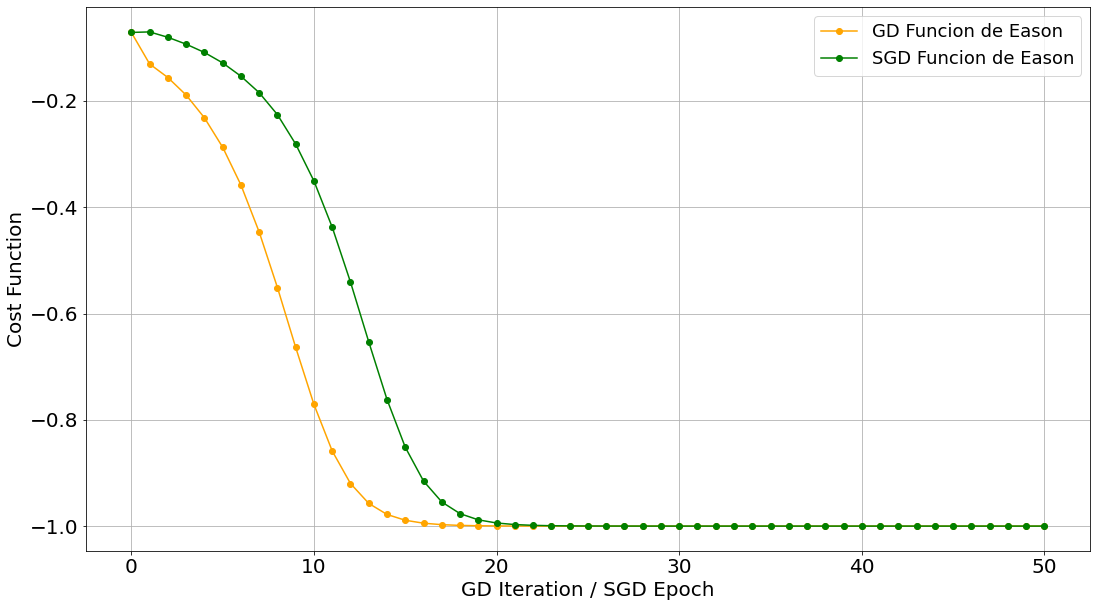

In [17]:
plt.figure(figsize=(18,10))

plt.plot(cost_GD_eason_taylor_fun_alpha2, '-o', color='orange', label='GD Funcion de Eason')
plt.plot(cost_SGD_eason_taylor_fun_alpha2, '-o', color='green', label='SGD Funcion de Eason')

plt.grid('on')
plt.xlabel('GD Iteration / SGD Epoch', fontsize= lsize)
plt.ylabel('Cost Function', fontsize= lsize)
plt.legend(loc='upper right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)
plt.show()

En la iteracion 0 previo a ejecutar el algoritmo no hay un valor para $x_{k-1}$ el cual se asumio 0, por lo que su gradiente no es la verdadera para la primera iteracion. Para SGD sin embargo ello solo afecto a la primera iteracion de la primera epoca.

Se puede apreciar ademas que el algoritmo GD tiene mejor rendimiento al poder calcular una gradiente mas verdadera al tomar todos los valores que conforman la gradiente completa.

Cabe notar que en ocasiones no se llega a un optimo, esto debido a que la funcion de costo tiene componentes sinusoidales oscilatorias, lo que hace que existan minimos locales. Debido a que la funcion de costo depende de 2 valores, se puede apreciar en 3 dimensiones la existencia de estas oscilaciones y de un miminimo global, al cual se alcanza dependiendo de los valores iniciales de x (los cuales se inicializan aleatoriamente).

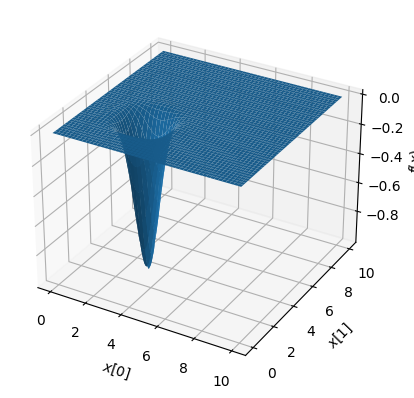

In [3]:
def f(x0, x1):
    return -np.cos(x0) * np.cos(x1) * np.exp(-(x0 - np.pi)**2 - (x1 - np.pi)**2)

x0 = np.linspace(0, 10, 1000)
x1 = np.linspace(0, 10, 1000)
X0, X1 = np.meshgrid(x0, x1)
f_x = f(X0, X1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0, X1, f_x)
ax.set_xlabel('$x[0]$')
ax.set_ylabel('$x[1]$')
ax.set_zlabel('$f(x)$')
plt.show()

Se puede apreciar un minimo global alrededor de $x[0]=\pi$ y $x[1]=\pi$. Ademas, la gradiente cambia de signo alrededor de $x[0]=1.3$, lo que puede hacer llegar a un minimo local dependiendo de $x[0]$ o $x[1]$ iniciales.

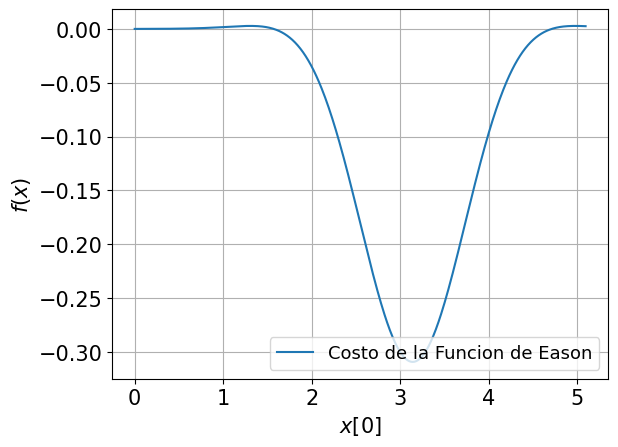

In [4]:
plt.plot(x0[0:510], f_x[400, 0:510], label='Costo de la Funcion de Eason')
lsize = 15
plt.grid('on')
plt.xlabel('$x[0]$', fontsize= lsize)
plt.ylabel('$f(x)$', fontsize= lsize)
plt.legend(loc='lower right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)

plt.show()

Se observa el cambio de signo de la gradiente en el eje $x[0]$ (lo mismo ocurre en $x[1]$).

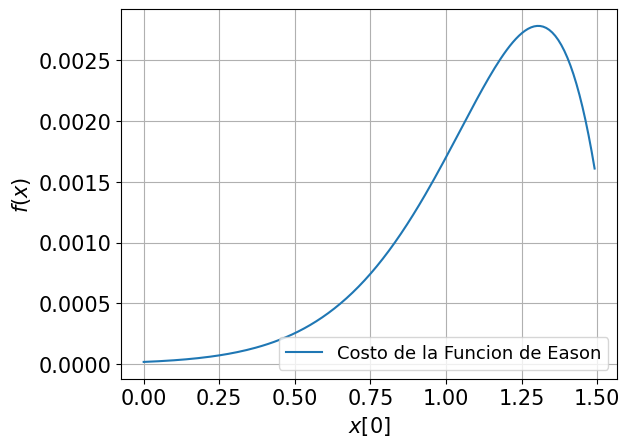

In [6]:
plt.plot(x0[0:150], f_x[400, 0:150], label='Costo de la Funcion de Eason')
plt.grid('on')
plt.xlabel('$x[0]$', fontsize= lsize)
plt.ylabel('$f(x)$', fontsize= lsize)
plt.legend(loc='lower right', fontsize= lsize-2)
plt.tick_params(axis='both',labelsize=lsize)

plt.show()